# Requirements

* download graph2vec code from  https://github.com/benedekrozemberczki/graph2vec
* NCI1 and NCI109 datasets
    

In [1]:
import pandas as pd
import numpy as np
import igraph as ig
import json
import os
import matplotlib.pyplot as plt
import umap, umap.plot
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn 
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier as rfc 
from collections import Counter

## pick one of the two datasets
datadir = '../Datasets/NCI1/'
#datadir = '../Datasets/NCI109/'

## location of graph2vec python code
g2v = './graph2vec/'

## Prepare datasets for graph2vec

* save each graph in a json file, where the filenames are 0-based integers
* each file contains a list of edges and dictionary of node features
* graph2vec code from: https://github.com/benedekrozemberczki/graph2vec

In [2]:
## read data from NCI folder
edges = datadir+'DS_A.txt'
graph_id = datadir+'DS_graph_indicator.txt'
graph_label = datadir+'DS_graph_labels.txt'
node_label = datadir+'DS_node_labels.txt'

## read edges, build overall graph
X = np.array(pd.read_csv(edges,header=None))
E = [list(x) for x in X]
G = ig.Graph.TupleList(E, directed=True)

## add missing vertices (isolates)
vertices = set(G.vs['name'])

## read subgraph membership (1-based)
m = [int(x) for x in np.array(pd.read_csv(graph_id,header=None))]

## add difference
v = set(np.arange(1,len(m)+1))
diff = v.difference(vertices)
G.add_vertices(list(diff))

## for plotting
G.vs['size'] = 10
G.vs['color'] = 'darkgrey'
G.es['color'] = 'grey'
G.es['arrow_size'] = .33
G.vs['label_size'] = 8

In [3]:
## mapping nodes in order of name
idx = list(np.argsort(G.vs['name']))

## assign subgraph
for i in range(len(m)):
    G.vs[idx[i]]['graph'] = m[i]

## verify with graph label list
l = [G.vs[i]['graph'] for i in idx]
l == m

True

In [4]:
## read node labels
l = [int(x) for x in np.array(pd.read_csv(node_label,header=None))]
for i in range(len(l)):
    G.vs[idx[i]]['label'] = l[i]
G = G.as_undirected()

## read graph labels
gl = [int(x) for x in np.array(pd.read_csv(graph_label,header=None))]


In [ ]:
## build the subgraphs and save json files
for gp in np.arange(1,np.max(G.vs['graph'])+1):
    v = [v for v in G.vs if v['graph']==gp]
    sg = G.subgraph(v)
    sg_edges = [list(e.tuple) for e in sg.es]
    sg_features = {str(v.index):str(v['label']) for v in sg.vs}
    sg_json = {"edges":sg_edges,"features":sg_features}
    fn = datadir+str(gp-1)+'.json'
    with open(fn,'w') as fp:
        json.dump(sg_json,fp)

## Run graph2vec 

adjust path accordingly


In [5]:
## run graph2vec 
cmd = 'python '+g2v+'graph2vec.py --input-path '+datadir+' --output-path '+datadir+\
'NCI.csv --dimensions 1024 --workers 1' 
x = os.system(cmd)


## Visualize embedding with UMAP

color w.r.t. graph label

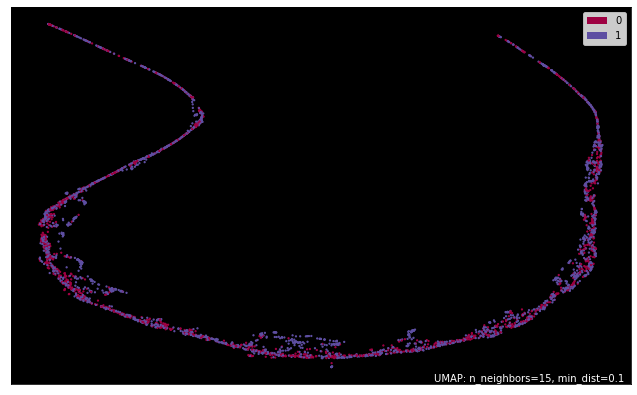

In [6]:
D = pd.read_csv(datadir+'NCI.csv')
D = np.array(D.drop(columns=['type']))
U = umap.UMAP(n_neighbors=15).fit(D)
umap.plot.points(U,labels=np.array(gl),theme='viridis',width=800,height=500);


## Classification in embedded space

* we use 90% for training, 10% for testing
* we try nearest-neighbour and random forest
* PROJECT: 
 - divide training set into training and validation 
 - use this to select best model by trying several hyperparameters

In [7]:
## divide data into training and testing
X_train, X_test, y_train, y_test = train_test_split(D, gl, test_size=0.1, random_state=0)

In [8]:
## k nearest neighbours classifier
knn_mdl = knn(n_neighbors=5)
knn_mdl.fit(X_train,y_train)
y_pred = knn_mdl.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6618004866180048


In [9]:
## random forest classifier
rfc_mdl = rfc(n_estimators=500,criterion='entropy')
rfc_mdl.fit(X_train,y_train)
y_pred = rfc_mdl.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6666666666666666


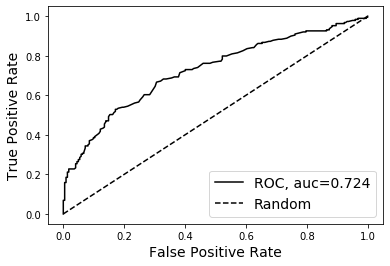

In [10]:
## ROC curve
y_probs = rfc_mdl.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_probs)
auc = metrics.roc_auc_score(y_test, y_probs)
plt.plot(fpr,tpr,label="ROC, auc="+str('%.3f' % auc),color='black')
plt.plot([0,1],[0,1],'--',label='Random',color='black')
plt.legend(loc=4,fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.show()


## Subgraph features

- we compute several statistics on the graphs
 - number of nodes, edges, density 
 - degree distribution 
 - number of components, size of the giant component
 - transitivity
 - degree assortativity
 - coreness distribution
 - node labels distribution
 
- we compare those for the two classes of graphs
- we perform binary classification using those features


label: 0


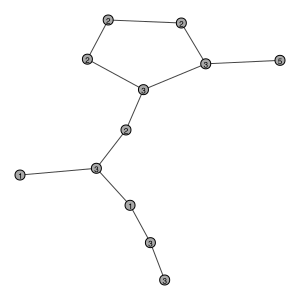

In [11]:
## example of a graph with label 0
gp = 500
v = [v for v in G.vs if v['graph']==gp]
sg = G.subgraph(v)
print('label:',gl[gp-1])
ig.plot(sg,bbox=(0,0,300,300))

label: 1


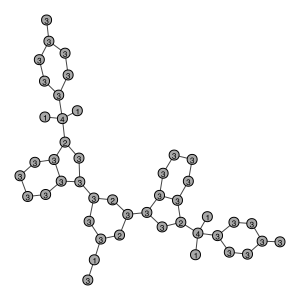

In [12]:
## example of a graph with label 1
gp = 2000
v = [v for v in G.vs if v['graph']==gp]
sg = G.subgraph(v)
print('label:',gl[gp-1])
ig.plot(sg,bbox=(0,0,300,300))

## Computing features fo each graph

In [13]:
def degrees(sg,md):
    ctr = Counter(sg.degree())
    return [ctr[i] for i in range(md+1)]

def core(sg,mc):
    ctr = Counter(sg.coreness())
    return [ctr[i] for i in range(mc+1)]

def labels(sg,ml):
    ctr = Counter(sg.vs['label'])
    return [ctr[i+1] for i in range(ml)]


In [14]:
## Compute features for each graph
L = []
md = np.max(G.degree())
mc = np.max(G.coreness())
ml = np.max(G.vs['label'])

for gp in np.arange(1,np.max(G.vs['graph'])+1):
    v = [v for v in G.vs if v['graph']==gp]
    sg = G.subgraph(v)
    ## node and edge counts, density
    x = [sg.vcount(),sg.ecount(),sg.ecount()/sg.vcount()]
    ## number of components, relative size of giant component
    x.extend([np.max(sg.clusters().membership)+1,sg.clusters().giant().vcount()/sg.vcount()])
    ## transitivity, assortativity
    x.extend([sg.transitivity_undirected(),sg.transitivity_avglocal_undirected()])
    ## assortativity
    a = sg.assortativity_degree()
    if np.isnan(a):
        a=0
    x.extend([a])
    ## degree distribution
    x.extend(degrees(sg,md))
    ## coreness distribution
    x.extend(core(sg,mc))
    ## node labels distribution
    x.extend(labels(sg,ml))
    L.append(x)

In [15]:
## store all features in a dataframe
col = ['nodes','edges','density','components','giant','trans','local trans','assort']
col.extend(['deg'+str(i) for i in np.arange(md+1)])
col.extend(['core'+str(i) for i in np.arange(mc+1)])
col.extend(['label'+str(i+1) for i in np.arange(ml)])
F = pd.DataFrame(L,columns=col)
F['type'] = gl
F.head()

,nodes,edges,density,components,giant,trans,local trans,assort,deg0,deg1,...,label29,label30,label31,label32,label33,label34,label35,label36,label37,type
0,21,21,1.000000,1,1.0,0.0,0.0,-0.542857,0,7,...,0,0,0,0,0,0,0,0,0,0
1,24,26,1.083333,1,1.0,0.0,0.0,-0.083333,0,4,...,0,0,0,0,0,0,0,0,0,0
2,29,29,1.000000,1,1.0,0.0,0.0,-0.440397,0,12,...,0,0,0,0,0,0,0,0,0,0
3,28,31,1.107143,1,1.0,0.0,0.0,-0.212291,0,4,...,0,0,0,0,0,0,0,0,0,0
4,23,23,1.000000,1,1.0,0.0,0.0,-0.286184,0,8,...,0,0,0,0,0,0,0,0,0,0


## Plot features

we selected a few and compare for graphs for type 0 or 1

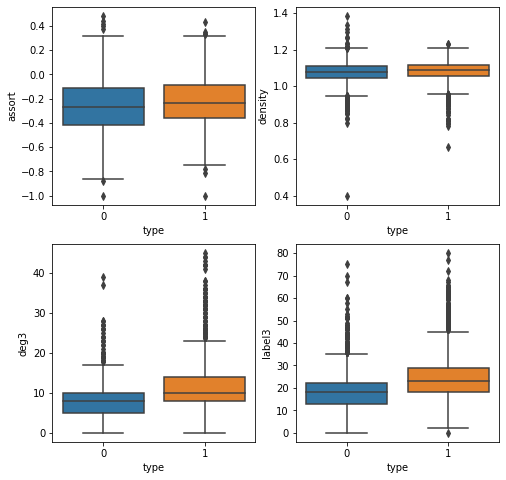

In [16]:
plt.subplots(2,2,figsize=(8,8))
plt.subplot(221)
sns.boxplot(x='type',y='assort',data=F)
plt.subplot(222)
sns.boxplot(x='type',y='density',data=F)
plt.subplot(223)
sns.boxplot(x='type',y='deg3',data=F)
plt.subplot(224)
sns.boxplot(x='type',y='label3',data=F);

In [17]:
## try binary classification with those features
## divide data into training and testing
A = np.array(F.drop(columns=['type']))
X_train, X_test, y_train, y_test = train_test_split(A, gl, test_size=0.1, random_state=0)

In [18]:
## k nearest neighbours classifier
knn_mdl = knn(n_neighbors=5)
knn_mdl.fit(X_train,y_train)
y_pred = knn_mdl.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7226277372262774


In [19]:
## random forest classifier
rfc_mdl = rfc(n_estimators=500,criterion='entropy')
rfc_mdl.fit(X_train,y_train)
y_pred = rfc_mdl.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.781021897810219


In [20]:
## most important features
x = np.argsort(rfc_mdl.feature_importances_)
top = [x[i] for i in np.arange(len(x)-1,-1,-1)]
top_features = [F.columns[i] for i in top]
top_features[:10]

['assort',
 'label3',
 'label1',
 'core2',
 'density',
 'core1',
 'deg3',
 'edges',
 'nodes',
 'deg2']